In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import metrics

# 심장병 발병 예측
```
1. Dataset 생성 & 전처리
    엑셀데이터 → ?를 nan → nan(결측치) 처리 → X, y 분리 → train/test Dataset 분리(API 이용)
2. Model 생성 & 구성 (과적합 줄이기 단계 추가)
3. Training Process Setting (accuracy, precision, recall)
4. Training (train dataset의 일부를 validation dataset으로 학습)
5. Model 평가 - 과정 살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)
6. 모델 사용하기
```

In [ ]:
#age - 나이
#sex - (1 = 남성; 0 = 여성)
#cp - 가슴 통증 유형(0, 1, 2, 3, 4)
#trestbps - 안정 혈압(병원 입원시 mm Hg)
#chol - 혈청 콜레스테롤(mg/dl)
#fbs - (공복 혈당 > 120 mg/dl)(1 = true; 0 = false)
#restecg - 안정 심전도 결과(0, 1, 2)
#thalach - 최대 심박동수
#exang - 협심증 유발 운동(1 = yes; 0 = no)
#oldpeak - 비교적 안정되기까지 운동으로 유발되는 ST depression
#slope - 최대 운동 ST segment의 기울기
#ca - 형광 투시된 주요 혈관의 수(0-3)
#thal - (3 = 보통; 6 = 해결된 결함; 7 = 해결가능한 결함)
#target - 심장병 진단(1 = true; 0 = false)

In [4]:
raw_data = pd.read_excel('./data/heart-disease.xlsx')
raw_data.head(3)

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [8]:
# raw_data의 타입이 object인 열에 ?가 있는 데이터 추출
raw_data[(raw_data['chol']=='?') | (raw_data['ca']=='?') | (raw_data['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [10]:
# '?'를 결측치(np.nan)로 대체
clean_data = raw_data.replace('?', np.nan)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [15]:
# clean_data에 결측치가 포함된 데이터 추출
clean_data[clean_data.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [18]:
# 결측치를 중앙값으로 대체
# 열별 중앙값 : clean_data.median(axis=0) 
clean_data.fillna(value=clean_data.median())

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,241.5,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [19]:
# 결측치가 하나라도 있는 행은 제거 
clean_data.dropna(how='any', inplace=True)
clean_data.isnull().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [20]:
clean_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236.0,0,0,178,0,0.8,1,0.0,3.0,0


In [23]:
Input = clean_data.iloc[:, :-1]
Target = clean_data.iloc[:, -1:]
Input.shape, Target.shape

((296, 13), (296, 1))

In [24]:
# 전체 296개 데이터 중 심장병이 걸린 데이터 수(1)
Target['heartDisease'].sum()

136

In [25]:
# 심장병이 걸린 데이터 확률
Target['heartDisease'].mean()

0.4594594594594595

In [26]:
# unique 별 데이터 갯수
Target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [28]:
# scale 조정 (Input 데이터만)
scaler = MinMaxScaler()
scaled_input = pd.DataFrame(scaler.fit_transform(Input))
print(Input.shape, scaled_input.shape)

(296, 13) (296, 13)


In [30]:
# scaled_input 와 Target -> 학습셋 : 시험셋 = 7:3
X_train, X_test, y_train, y_test = train_test_split(scaled_input, # 입력변수(독립변수)
                Target, # 타겟변수(종속변수)
                test_size=0.3,
                random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((207, 13), (89, 13), (207, 1), (89, 1))

## 2.모델 생성 & 구성(과적합 줄이기 단계 추가)

In [31]:
model = Sequential()
model.add(Dense(units=500,
               input_dim=13,
               activation='tanh'))
# 과적합을 해결하고자 dropout (두루뭉실하게 출력)
model.add(Dropout(0.1))
model.add(Dense(units=200,
               activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(units=100,
               activation='tanh'))
model.add(Dropout(0.1))
# 출력층에서의 활성화 함수 : 이진분류(로지스틱회귀)에서는 sigmoid / 원핫인코딩을 한 분류분석에서는 softmax
model.add(Dense(units=1,
               activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               7000      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

## 3.모델 학습과정설정

In [32]:
# 분류분석일 때, 성능평가지표
# 정확도(accuracy) : 예측결과와 실제값이 동일한 건수 / 전체 건수
# precision(정밀도, 민감도): 실제도True 인데 예측도 True로 맞춘 건수 / True로 예측한 건수
# recall(재현율) : 실제 True 인데 예측도 True로 맞춘 건수 / 실제가 True 인 건수
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy', metrics.Recall(), metrics.Precision()])

In [33]:
hist = model.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=100, 
                 verbose=1,
                 validation_split=0.2, # 훈련데이터 셋의 20%를 검증데이터 셋으로
                )

Epoch 1/100
2/2 [==============================] - 2s 294ms/step - loss: 0.6501 - accuracy: 0.6121 - recall: 0.8961 - precision: 0.5520 - val_loss: 0.5264 - val_accuracy: 0.7619 - val_recall: 0.6842 - val_precision: 0.7647
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 0.5350 - accuracy: 0.7879 - recall: 0.7922 - precision: 0.7625 - val_loss: 0.4410 - val_accuracy: 0.7619 - val_recall: 0.6842 - val_precision: 0.7647
Epoch 3/100
2/2 [==============================] - 0s 43ms/step - loss: 0.4684 - accuracy: 0.7879 - recall: 0.7662 - precision: 0.7763 - val_loss: 0.4064 - val_accuracy: 0.7619 - val_recall: 0.6842 - val_precision: 0.7647
Epoch 4/100
2/2 [==============================] - 0s 41ms/step - loss: 0.4357 - accuracy: 0.8242 - recall: 0.8182 - precision: 0.8077 - val_loss: 0.3838 - val_accuracy: 0.8095 - val_recall: 0.6842 - val_precision: 0.8667
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.4388 - accuracy: 0.8182 - recall: 0.8

Epoch 38/100
2/2 [==============================] - 0s 33ms/step - loss: 0.3606 - accuracy: 0.8848 - recall: 0.8571 - precision: 0.8919 - val_loss: 0.3753 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 39/100
2/2 [==============================] - 0s 32ms/step - loss: 0.3676 - accuracy: 0.8545 - recall: 0.8052 - precision: 0.8732 - val_loss: 0.3732 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 40/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3739 - accuracy: 0.8485 - recall: 0.7662 - precision: 0.8939 - val_loss: 0.3720 - val_accuracy: 0.8571 - val_recall: 0.7895 - val_precision: 0.8824
Epoch 41/100
2/2 [==============================] - 0s 38ms/step - loss: 0.3741 - accuracy: 0.8485 - recall: 0.8052 - precision: 0.8611 - val_loss: 0.3745 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 42/100
2/2 [==============================] - 0s 46ms/step - loss: 0.3646 - accuracy: 0.8545 - recall:

Epoch 75/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3156 - accuracy: 0.8667 - recall: 0.8701 - precision: 0.8481 - val_loss: 0.3923 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 76/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3201 - accuracy: 0.8485 - recall: 0.8052 - precision: 0.8611 - val_loss: 0.3857 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 77/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3043 - accuracy: 0.8727 - recall: 0.8052 - precision: 0.9118 - val_loss: 0.3835 - val_accuracy: 0.8810 - val_recall: 0.8421 - val_precision: 0.8889
Epoch 78/100
2/2 [==============================] - 0s 34ms/step - loss: 0.3120 - accuracy: 0.8606 - recall: 0.8182 - precision: 0.8750 - val_loss: 0.3902 - val_accuracy: 0.8571 - val_recall: 0.8421 - val_precision: 0.8421
Epoch 79/100
2/2 [==============================] - 0s 34ms/step - loss: 0.3112 - accuracy: 0.8667 - recall:

In [34]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

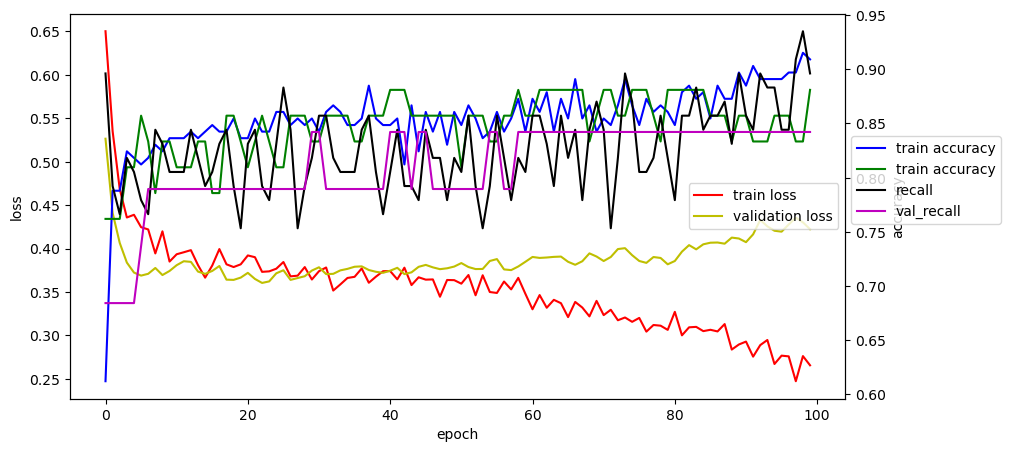

In [37]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['recall'], 'k', label='recall')
acc_ax.plot(hist.history['val_recall'], 'm', label='val_recall')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [40]:
# 모델 평가 
score = model.evaluate(X_test, y_test)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model recall :', score[2])
print('model precision :', score[3])

3/3 [==============================] - 0s 6ms/step - loss: 0.4136 - accuracy: 0.8090 - recall: 0.7750 - precision: 0.7949
model loss : 0.41363710165023804
model accuracy : 0.8089887499809265
model recall : 0.7749999761581421
model precision : 0.7948718070983887


In [46]:
# 교차표 = confusion matrix (매개변수에 2차원 데이터)
y_hat = (model.predict(X_test)>0.5).astype(int)
print(y_hat.shape)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print(confusion_matrix(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

3/3 [==============================] - 0s 3ms/step
(89, 1)
[[41  8]
 [ 9 31]]
f1 score : 0.7848101265822786


In [47]:
# crosstab (매개변수에 1차원 데이터)
pd.crosstab(y_test.values.reshape(-1), # 실제값(1차원)
           y_hat.reshape(-1)) # 예측값(1차원)

col_0,0,1
row_0,,
0,41,8
1,9,31
